<a href="https://colab.research.google.com/github/MarcusASCruz/Exploratory-Correlation-Analysis-and-IA-Modeling-Evaluation/blob/main/GitHUB_HydroAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# 1. IMPORTAÇÕES E DRIVE
# =========================
# (célula 1)

# Instale scikeras se for necessário
!pip install scikeras
!pip install xgboost # Instale xgboost se for necessário

import itertools
import matplotlib.pyplot as plt # matplotlib geralmente não usa GPU
from google.colab import drive # Mova a importação para fora do bloco try/except

# Importar SimpleImputer do sklearn fora do try/except para garantir que esteja sempre disponível
from sklearn.impute import SimpleImputer

# IMPORTAR numpy AS np AQUI FORA DO TRY/EXCEPT
import numpy as np

# IMPORTAR XGBoost AQUI FORA DO TRY/EXCEPT para garantir que esteja sempre disponível
from xgboost import XGBRegressor

# Importar modelos scikit-learn comuns que podem ser usados como fallback ou baseline
# Importe-os AQUI fora do try/except para que estejam SEMPRE disponíveis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor, # Importar GradientBoostingRegressor aqui
    AdaBoostRegressor,         # Importar AdaBoostRegressor aqui
    ExtraTreesRegressor,       # Importar ExtraTreesRegressor aqui
    HistGradientBoostingRegressor # Importar HistGradientBoostingRegressor aqui
)
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Flatten
from scikeras.wrappers import KerasRegressor
from functools import partial

# Importar cudf e cuml no lugar de pandas e algumas partes do sklearn
# É essencial importar cudf ANTES de pandas se você usar a mágica %load_ext cudf.pandas
# ou se quiser substituir todas as chamadas pandas por cudf.
# Para usar a aceleração do pandas com a API original, use a mágica.
try:
    from cudf import DataFrame as cuDF
    # Use os nomes originais do cuml onde eles substituem os do sklearn
    from cuml.model_selection import train_test_split as cuml_train_test_split
    from cuml.preprocessing import MinMaxScaler as cuml_MinMaxScaler
    from cuml.preprocessing import StandardScaler as cuml_StandardScaler
    # Tentar importar cuml.impute, mas estar preparado para o fallback
    try:
        from cuml.impute import SimpleImputer as cuml_SimpleImputer
        print("cuml.impute.SimpleImputer importado com sucesso.")
    except ImportError:
        print("cuml.impute.SimpleImputer não encontrado. Usando sklearn.impute.SimpleImputer.")
        # Usar o SimpleImputer do sklearn importado globalmente
        cuml_SimpleImputer = SimpleImputer

    # Use os nomes originais do cuml onde eles substituem os do sklearn
    from cuml.metrics.regression import mean_squared_error as cuml_mean_squared_error
    from cuml.metrics.regression import r2_score as cuml_r2_score
    from cuml.ensemble import RandomForestRegressor as cuml_RandomForestRegressor
    from cuml.svm import SVR as cuml_SVR
    # Outras importações cuml para os modelos que você pretende acelerar

    print("Bibliotecas RAPIDS importadas com sucesso.")

    # Aliar os nomes cuml para os nomes que serão usados globalmente
    # Estes aliases só são necessários se você quiser se referir a eles por um nome diferente
    # Mas como estamos importando os do sklearn globalmente, vamos apenas garantir
    # que as variáveis com nomes cuml_* apontem para as versões cuml.
    # Não precisamos realiar as versões do sklearn aqui.

except ImportError:
    print("RAPIDS não encontrado (cudf ou cuml). As operações serão executadas na CPU.")
    # No fallback, os aliases cuml_* devem apontar para os objetos sklearn importados globalmente
    cuml_train_test_split = train_test_split
    cuml_MinMaxScaler = MinMaxScaler
    cuml_StandardScaler = StandardScaler
    # cuml_SimpleImputer já foi definido no try, aqui garantimos que aponte para o sklearn
    # Se o try falhou, cuml_SimpleImputer já foi definido com SimpleImputer.
    # Se o try teve sucesso, cuml_SimpleImputer aponta para cuml.impute.SimpleImputer.
    # Não precisamos reatribuir aqui.

    cuml_mean_squared_error = mean_squared_error
    cuml_r2_score = r2_score
    # Aliar os aliases cuml para os modelos sklearn importados globalmente
    cuml_RandomForestRegressor = RandomForestRegressor
    cuml_SVR = SVR
    # Mapear outros modelos para suas versões cuml ou manter as originais se não houver
    # cuDF deve mapear para pandas DataFrame
    import pandas as pd
    cuDF = pd.DataFrame

# Opcional: Usar a mágica para acelerar o pandas, se preferir
# %%capture
# %load_ext cudf.pandas
# import pandas as pd # Importar pandas DEPOIS da mágica




cuml.impute.SimpleImputer não encontrado. Usando sklearn.impute.SimpleImputer.
Bibliotecas RAPIDS importadas com sucesso.
Mounted at /content/drive


In [ ]:
# ======================
# 2. CARREGAR DADOS
# ======================

# Certifique-se de importar cudf corretamente
import os
import cudf

data_path = '/data/seuarquivo.csv'
try:
    data = cudf.read_csv(data_path, delimiter=';')
    print("Dados carregados com sucesso na GPU (cudf DataFrame).")
except FileNotFoundError:
    print("Erro: Arquivo não encontrado. Verifique o caminho do arquivo.")
    raise
except Exception as e:
    print(f"Erro ao carregar dados com cudf: {e}. Tentando carregar com pandas (CPU).")
    import pandas as pd
    data = pd.read_csv(data_path, delimiter=';')
    print("Dados carregados com sucesso na CPU (pandas DataFrame).")

if isinstance(data, cudf.DataFrame):
    data_pd = data.to_pandas()
else:
    data_pd = data

desc_stats = data_pd.describe()
print(desc_stats)

# Nome do arquivo de saída baseado no nome do arquivo de entrada e salvo no mesmo diretório
dir_name = os.path.dirname(data_path)
base_name = os.path.splitext(os.path.basename(data_path))[0]
out_file = os.path.join(dir_name, f"{base_name}_estatistica_descritiva.csv")

desc_stats.to_csv(out_file)

Dados carregados com sucesso na GPU (cudf DataFrame).
       Qaf_Sobradinho  QPontExtr_acum10_lag10  QBoquAflu_acum10_lag10  \
count     1418.000000             1417.000000             1417.000000   
mean      1823.346577              282.692953              251.919269   
std       1453.973115              302.662265               81.247070   
min        214.000000                7.292800              120.512690   
25%        947.000000               99.738570              193.147220   
50%       1295.000000              170.291460              234.504800   
75%       2308.725000              343.569040              298.835690   
max      15429.000000             2385.446700              830.423910   

       QPirapora_acum10_lag10  prTresMarias_acum10_lag20  \
count             1417.000000                1416.000000   
mean               718.234637                  34.484962   
std                477.802205                  46.080562   
min                112.141200                   

In [ ]:
# ===========================
# 3. SELEÇÃO DA VARIÁVEL ALVO
# ===========================
# (célula 3)
print(f"\nColunas disponíveis e seus índices:")
# Iterar sobre as colunas do DataFrame (funciona tanto para pandas quanto cudf)
for i, column in enumerate(data.columns):
    print(f"{i}: {column}")

target_index = int(input("Selecione o índice da variável alvo: "))
target_variable = data.columns[target_index]
print(f"Variável alvo selecionada: {target_variable}")


Colunas disponíveis e seus índices:
0: Qaf_Sobradinho
1: prTresMarias_acum30_lag30
2: prUrucuia_acum30_lag30
3: prPacuiMangai_acum30_lag30
4: prPandPeru_acum30_lag30
5: prParacatu_acum30_lag30
6: prJequitai_acum30_lag30
7: prPara_acum30_lag30
8: prVerdeGrande_acum30_lag30
9: prAltoSF_acum30_lag30
10: prVelhas_acum30_lag30
11: prRas_acum30_lag30
12: prParaopeba_acum30_lag30
13: prCorrente_acum30_lag30
14: prCarinhana_acum30_lag30
15: prGrande_acum30_lag30
16: QPontExtr_acum30_lag30
17: prParamSO_acum30_lag30
18: QPirapora_acum30_lag30
19: etoPara_acum30_lag600
20: etoParaopeba_acum30_lag240
Selecione o índice da variável alvo: 0
Variável alvo selecionada: Qaf_Sobradinho


Attempting imputation...
Using sklearn.SimpleImputer with cuDF, converting to numpy for imputation...
Result converted back to cuDF after sklearn imputation.
Imputation completed successfully. Result type: <class 'cudf.core.dataframe.DataFrame'>

Attempting scaling...
Using sklearn.StandardScaler with pandas/numpy...
Scaling completed with sklearn scaler.
Scaling completed successfully. Result type: <class 'pandas.core.frame.DataFrame'>

Attempting to calculate Feature Importance...
Attempting to fit cuml_RandomForestRegressor with input types: <class 'numpy.ndarray'> and <class 'numpy.ndarray'>
Using sklearn RandomForestRegressor...

Importância das Características (estimada por Random Forest):
                       Feature  Importance
0    prTresMarias_acum30_lag30    0.370841
15      QPontExtr_acum30_lag30    0.243688
17      QPirapora_acum30_lag30    0.090742
1       prUrucuia_acum30_lag30    0.062970
3      prPandPeru_acum30_lag30    0.033306
6          prPara_acum30_lag30    0.0

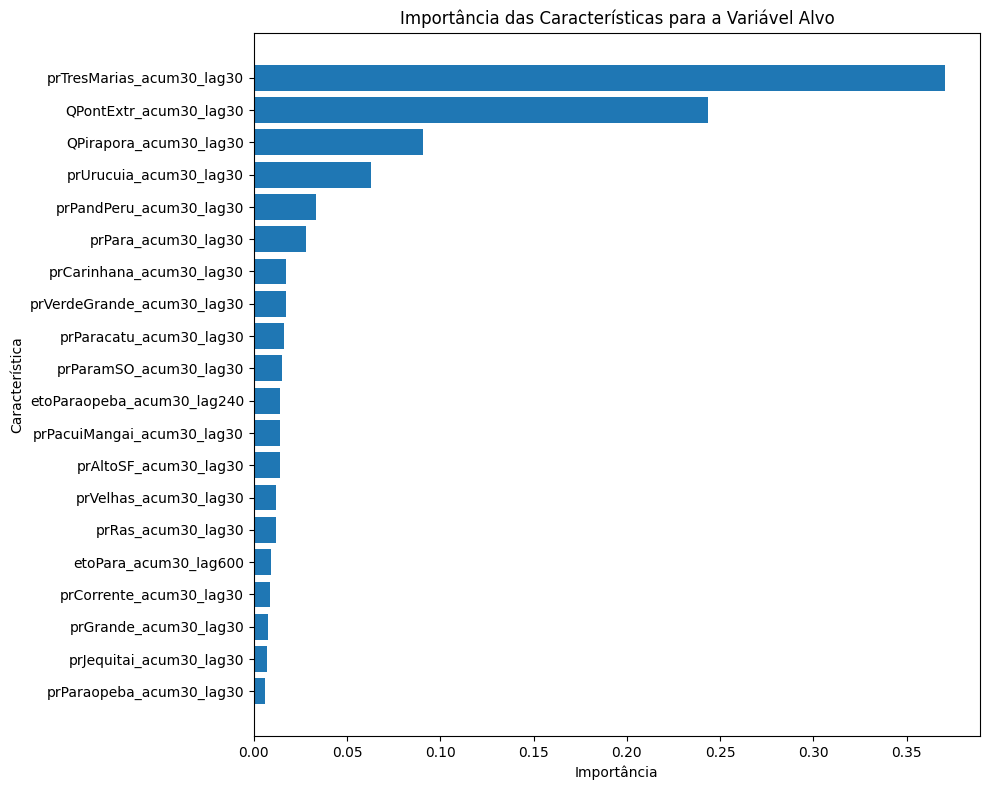

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# Infere janela de dias do nome do arquivo usado na célula 2
def infer_window_from_filename(filename):
    match = re.search(r'(\d+)dia', filename)
    if match:
        return int(match.group(1))
    return None

# Usa o mesmo caminho do arquivo carregado na célula 2
janela_dias = infer_window_from_filename(os.path.basename(data_path))

# Características possíveis (todas exceto a alvo)
all_possible_features = [col for col in data.columns if col != target_variable]

# Certifique-se de que X_all e y sejam DataFrames/Series do RAPIDS (cuDF) se RAPIDS estiver disponível
X_all = data[all_possible_features]
y = data[target_variable]

# Detecta se RAPIDS está carregado
try:
    is_rapids_loaded = 'cuDF' in globals() and isinstance(data, cuDF) and str(type(globals().get('cuDF'))) != "<class 'pandas.core.frame.DataFrame'>"
except NameError:
    is_rapids_loaded = False

X_all_imputed = None

try:
    print("Attempting imputation...")
    if cuml_SimpleImputer.__module__ == 'sklearn.impute._base' and isinstance(X_all, cuDF):
        print("Using sklearn.SimpleImputer with cuDF, converting to numpy for imputation...")
        imputer_importance = cuml_SimpleImputer(strategy='median')
        X_all_imputed_np = imputer_importance.fit_transform(X_all.to_pandas().to_numpy())
        if is_rapids_loaded:
            X_all_imputed = cuDF(X_all_imputed_np, columns=all_possible_features)
            print("Result converted back to cuDF after sklearn imputation.")
        else:
            X_all_imputed = pd.DataFrame(X_all_imputed_np, columns=all_possible_features)
            print("Result kept as pandas DataFrame after sklearn imputation.")

    elif cuml_SimpleImputer.__module__ == 'cuml.impute._simple':
        print("Using cuml.impute.SimpleImputer with cuDF/pandas...")
        imputer_importance = cuml_SimpleImputer(strategy='median')
        X_all_imputed = imputer_importance.fit_transform(X_all)
        print("Imputation completed with cuml imputer.")
    else:
        print("Using sklearn.SimpleImputer with pandas/numpy...")
        X_for_imputation = X_all.to_pandas() if isinstance(X_all, cuDF) else X_all
        imputer_importance = cuml_SimpleImputer(strategy='median')
        X_all_imputed = imputer_importance.fit_transform(X_for_imputation)
        if isinstance(X_for_imputation, pd.DataFrame) and not isinstance(X_all_imputed, pd.DataFrame):
            X_all_imputed = pd.DataFrame(X_all_imputed, columns=all_possible_features)
            print("Result converted back to pandas DataFrame after sklearn imputation.")
        print("Imputation completed with sklearn imputer.")

    if X_all_imputed is not None:
        print(f"Imputation completed successfully. Result type: {type(X_all_imputed)}")
    else:
        print("Imputation logic did not produce a result.")

except Exception as e:
    print(f"An unexpected error occurred during imputation attempt: {e}.")
    print("Ensuring data is in numpy format for imputation fallback...")
    if isinstance(X_all, cuDF):
        X_all_np = X_all.to_pandas().to_numpy()
        print("Convertido de cuDF para pandas para numpy para imputação.")
    elif isinstance(X_all, pd.DataFrame):
        X_all_np = X_all.to_numpy()
        print("Convertido de pandas para numpy para imputação.")
    else:
        X_all_np = X_all
        print("Dados já em formato numpy para imputação.")

    from sklearn.impute import SimpleImputer as SklearnSimpleImputer
    imputer_importance = SklearnSimpleImputer(strategy='median')
    X_all_imputed_np = imputer_importance.fit_transform(X_all_np)
    print("Imputation completed successfully using sklearn imputer with numpy fallback.")

    try:
        is_rapids_loaded_check = isinstance(data, cuDF) and str(type(globals().get('cuDF'))) != "<class 'pandas.core.frame.DataFrame'>"
    except NameError:
        is_rapids_loaded_check = False

    if isinstance(X_all, cuDF) and is_rapids_loaded_check:
        X_all_imputed = cuDF(X_all_imputed_np, columns=all_possible_features)
        print("Resultado da imputação numpy convertido de volta para cuDF.")
    elif isinstance(X_all, pd.DataFrame) or not is_rapids_loaded_check:
        X_all_imputed = pd.DataFrame(X_all_imputed_np, columns=all_possible_features)
        print("Resultado da imputação numpy convertido de volta para pandas DataFrame.")
    else:
        X_all_imputed = X_all_imputed_np
        print("Resultado mantido como numpy após fallback imputation.")

    print(f"Imputation fallback completed. Result type: {type(X_all_imputed)}")

# Escalonamento
X_all_scaled_std = None
try:
    print("\nAttempting scaling...")
    try:
        is_rapids_loaded_check = isinstance(data, cuDF) and str(type(globals().get('cuDF'))) != "<class 'pandas.core.frame.DataFrame'>"
    except NameError:
        is_rapids_loaded_check = False

    if cuml_StandardScaler.__module__ == 'sklearn.preprocessing._data' and isinstance(X_all_imputed, cuDF):
        print("Using sklearn.StandardScaler with cuDF, converting to numpy for scaling...")
        scaler_std_importance = cuml_StandardScaler()
        X_all_imputed_np_for_scaling = X_all_imputed.to_numpy()
        X_all_scaled_std_np = scaler_std_importance.fit_transform(X_all_imputed_np_for_scaling)
        if is_rapids_loaded_check:
            X_all_scaled_std = cuDF(X_all_scaled_std_np, columns=all_possible_features)
            print("Result converted back to cuDF after sklearn scaling.")
        else:
            X_all_scaled_std = pd.DataFrame(X_all_scaled_std_np, columns=all_possible_features)
            print("Result kept as pandas DataFrame after sklearn scaling.")

    elif cuml_StandardScaler.__module__ == 'cuml.preprocessing.data':
        print("Using cuml.preprocessing.StandardScaler with cuDF/pandas...")
        scaler_std_importance = cuml_StandardScaler()
        X_all_scaled_std = scaler_std_importance.fit_transform(X_all_imputed)
        print("Scaling completed with cuml scaler.")
    else:
        print("Using sklearn.StandardScaler with pandas/numpy...")
        X_for_scaling = X_all_imputed.to_pandas() if isinstance(X_all_imputed, cuDF) else X_all_imputed
        scaler_std_importance = cuml_StandardScaler()
        X_all_scaled_std = scaler_std_importance.fit_transform(X_for_scaling)
        if isinstance(X_for_scaling, pd.DataFrame) and not isinstance(X_all_scaled_std, pd.DataFrame):
            X_all_scaled_std = pd.DataFrame(X_all_scaled_std, columns=all_possible_features)
            print("Result converted back to pandas DataFrame after sklearn scaling.")
        print("Scaling completed with sklearn scaler.")

    if X_all_scaled_std is not None:
        print(f"Scaling completed successfully. Result type: {type(X_all_scaled_std)}")
    else:
        print("Scaling logic did not produce a result.")

except Exception as e:
    print(f"An unexpected error occurred during scaling attempt: {e}.")
    print("Ensuring data is in numpy format for scaling fallback...")
    if isinstance(X_all_imputed, cuDF):
        X_all_imputed_np_for_scaling_fallback = X_all_imputed.to_numpy()
        print("Convertido de cuDF para numpy para escalonamento.")
    elif isinstance(X_all_imputed, pd.DataFrame):
        X_all_imputed_np_for_scaling_fallback = X_all_imputed.to_numpy()
        print("Convertido de pandas para numpy para escalonamento.")
    else:
        X_all_imputed_np_for_scaling_fallback = X_all_imputed
        print("Dados já em formato numpy para escalonamento.")

    from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
    scaler_std_importance = SklearnStandardScaler()
    X_all_scaled_std_np_fallback = scaler_std_importance.fit_transform(X_all_imputed_np_for_scaling_fallback)
    print("Scaling completed successfully using sklearn scaler with numpy fallback.")

    try:
        is_rapids_loaded_check = isinstance(data, cuDF) and str(type(globals().get('cuDF'))) != "<class 'pandas.core.frame.DataFrame'>"
    except NameError:
        is_rapids_loaded_check = False

    if isinstance(X_all_imputed, cuDF) and is_rapids_loaded_check:
        X_all_scaled_std = cuDF(X_all_scaled_std_np_fallback, columns=all_possible_features)
        print("Resultado do escalonamento numpy convertido de volta para cuDF.")
    elif isinstance(X_all_imputed, pd.DataFrame) or not is_rapids_loaded_check:
        X_all_scaled_std = pd.DataFrame(X_all_scaled_std_np_fallback, columns=all_possible_features)
        print("Resultado do escalonamento numpy convertido de volta para pandas DataFrame.")
    else:
        X_all_scaled_std = X_all_scaled_std_np_fallback
        print("Resultado mantido como numpy após fallback scaling.")

    print(f"Scaling fallback completed. Result type: {type(X_all_scaled_std)}")

# Importância via Random Forest
try:
    print("\nAttempting to calculate Feature Importance...")
    X_for_fit = X_all_scaled_std.to_numpy() if hasattr(X_all_scaled_std, 'to_numpy') else (X_all_scaled_std.values if hasattr(X_all_scaled_std, 'values') else X_all_scaled_std)
    y_for_fit = y.to_numpy() if hasattr(y, 'to_numpy') else (y.values if hasattr(y, 'values') else y)

    try:
        is_rapids_loaded_check = isinstance(data, cuDF) and str(type(globals().get('cuDF'))) != "<class 'pandas.core.frame.DataFrame'>"
    except NameError:
        is_rapids_loaded_check = False

    print(f"Attempting to fit cuml_RandomForestRegressor with input types: {type(X_for_fit)} and {type(y_for_fit)}")

    if cuml_RandomForestRegressor.__module__ == 'cuml.ensemble.randomforest_common' and is_rapids_loaded_check:
        print("Using cuML RandomForestRegressor...")
        temp_model = cuml_RandomForestRegressor(n_estimators=100, random_state=42)
        temp_model.fit(X_for_fit, y_for_fit)
    else:
        import pandas as pd
        from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor
        print("Using sklearn RandomForestRegressor...")
        temp_model = SklearnRandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        temp_model.fit(X_for_fit, y_for_fit)

    feature_importances_values = temp_model.feature_importances_

    print("\nImportância das Características (estimada por Random Forest):")

except Exception as e:
    print(f"Error during feature importance calculation with RandomForestRegressor: {e}.")
    print("Ensuring fallback to scikit-learn RandomForestRegressor for feature importance.")

    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor

    X_for_fit_sklearn = X_all_scaled_std.to_numpy() if hasattr(X_all_scaled_std, 'to_numpy') else (X_all_scaled_std.values if hasattr(X_all_scaled_std, 'values') else X_all_scaled_std)
    y_for_fit_sklearn = y.to_numpy() if hasattr(y, 'to_numpy') else (y.values if hasattr(y, 'values') else y)

    print(f"Attempting to fit sklearn.ensemble.RandomForestRegressor with input types: {type(X_for_fit_sklearn)} and {type(y_for_fit_sklearn)}")

    sklearn_model = SklearnRandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    sklearn_model.fit(X_for_fit_sklearn, y_for_fit_sklearn)

    feature_importances_values = sklearn_model.feature_importances_

    print("\nImportância das Características (estimada por Random Forest - sklearn fallback):")

feature_importances = pd.DataFrame({
    'Feature': list(all_possible_features),
    'Importance': feature_importances_values
}).sort_values('Importance', ascending=False)

print(feature_importances)

# SALVAR EM CSV na pasta do Google Drive inicial
gdrive_base_folder = '/content/drive/MyDrive/GeoBSF/'  # ajuste se seu mount for diferente

# Salva com nome automático a partir da janela inferida
try:
    if janela_dias is not None:
        csv_filename = f"feature_importances_janela_{janela_dias}d.csv"
        csv_path = os.path.join(gdrive_base_folder, csv_filename)
        feature_importances.to_csv(csv_path, index=False, encoding='utf-8')
        print(f"As importâncias das features foram salvas em: {csv_path}")
    else:
        print("Não foi possível inferir a janela de dias do nome do arquivo. Salvando com nome padrão.")
        csv_path = os.path.join(gdrive_base_folder, "feature_importances.csv")
        feature_importances.to_csv(csv_path, index=False, encoding='utf-8')
        print(f"As importâncias das features foram salvas em: {csv_path}")
except Exception as e:
    print(f"Erro ao salvar as importâncias das features: {e}")

# PLOTAGEM
plt.figure(figsize=(10, len(all_possible_features) * 0.4))
plt.title('Importância das Características para a Variável Alvo')
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importância')
plt.ylabel('Característica')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# 4. SELEÇÃO DAS FEATURES
# =========================
# (célula 4)
print("As características e seus índices são:")
for i, feat in enumerate(feature_importances['Feature']):
    print(f"{i}: {feat}")

all_features_input = input("Usar todas as características mostradas no gráfico de importância? (y/n): ")
if all_features_input.lower() == 'n':
    selected_indices_str = input("Digite os índices das características a serem usadas (separados por vírgulas): ")
    selected_indices = [int(i.strip()) for i in selected_indices_str.split(',')]
    features = [feature_importances['Feature'].iloc[i] for i in selected_indices]
else:
    features = list(feature_importances['Feature'])

print("Características selecionadas:", features)

X = data[features]
y = data[target_variable]

As características e seus índices são:
0: prTresMarias_acum30_lag30
1: QPontExtr_acum30_lag30
2: QPirapora_acum30_lag30
3: prUrucuia_acum30_lag30
4: prPandPeru_acum30_lag30
5: prPara_acum30_lag30
6: prCarinhana_acum30_lag30
7: prVerdeGrande_acum30_lag30
8: prParacatu_acum30_lag30
9: prParamSO_acum30_lag30
10: etoParaopeba_acum30_lag240
11: prPacuiMangai_acum30_lag30
12: prAltoSF_acum30_lag30
13: prVelhas_acum30_lag30
14: prRas_acum30_lag30
15: etoPara_acum30_lag600
16: prCorrente_acum30_lag30
17: prGrande_acum30_lag30
18: prJequitai_acum30_lag30
19: prParaopeba_acum30_lag30
Usar todas as características mostradas no gráfico de importância? (y/n): y
Características selecionadas: ['prTresMarias_acum30_lag30', 'QPontExtr_acum30_lag30', 'QPirapora_acum30_lag30', 'prUrucuia_acum30_lag30', 'prPandPeru_acum30_lag30', 'prPara_acum30_lag30', 'prCarinhana_acum30_lag30', 'prVerdeGrande_acum30_lag30', 'prParacatu_acum30_lag30', 'prParamSO_acum30_lag30', 'etoParaopeba_acum30_lag240', 'prPacuiMangai

In [ ]:
# =========================
# 5. PREPARAÇÃO DOS DADOS
# =========================
# (célula 5)

# Determine if the imputer is the sklearn version and the input is cuDF
is_sklearn_imputer = cuml_SimpleImputer.__module__ == 'sklearn.impute._base'
is_input_cudf = isinstance(X, cudf.DataFrame)

# Ensure SimpleImputer is correctly imported as cuml_SimpleImputer in Cell 1
imputer = cuml_SimpleImputer(strategy='median') # Use the aliased imputer from Cell 1

# Explicitly convert X to NumPy if using sklearn imputer with cuDF
if is_sklearn_imputer and is_input_cudf:
    print("Using sklearn imputer with cuDF input, converting X to numpy for imputation.")
    # Use .to_pandas().to_numpy() to safely handle nulls during conversion
    X_for_imputation = X.to_pandas().to_numpy()
elif isinstance(X, cudf.DataFrame) and not is_input_cudf:
     # This case should not happen based on the check `is_input_cudf`,
     # but as a safeguard, if X is cuDF but is_input_cudf is somehow False,
     # also convert via pandas.
     print("X is cuDF but is_input_cudf is False, converting X to numpy via pandas for imputation.")
     X_for_imputation = X.to_pandas().to_numpy()
else:
    # Otherwise, use X directly (either pandas DataFrame, cuml DataFrame, or already numpy)
    # Pandas DataFrames are handled by sklearn imputers directly.
    # cuml DataFrames are handled by cuml imputers directly.
    # numpy arrays are handled by sklearn imputers directly.
    X_for_imputation = X

# Perform imputation
# The imputer will now receive data in a format it can handle (numpy for sklearn, cuDF/pandas for cuml)
X_imputed = imputer.fit_transform(X_for_imputation)

# If the original input was cuDF and the result is a numpy array (from sklearn imputer),
# convert it back to cuDF if RAPIDS was loaded, or to pandas if not.
# The 'is_rapids_loaded' variable is defined in Cell 4, ensure it's accessible or redefine if needed.
# Let's assume is_rapids_loaded is accessible from Cell 4.
# We also need to check if the imputation result is actually a numpy array before attempting to convert it back.
if isinstance(X_imputed, np.ndarray) and (is_sklearn_imputer and is_input_cudf):
    print("Imputation result is numpy, converting back to original type if possible.")
    # Redefine is_rapids_loaded or ensure it's available
    try:
        is_rapids_loaded_check = isinstance(data, cuDF) and str(type(cuDF)) != "<class 'pandas.core.frame.DataFrame'>"
    except NameError:
         # Fallback if cuDF is not defined, assume RAPIDS is not loaded
         is_rapids_loaded_check = False

    if is_rapids_loaded_check:
         # Recreate the cuDF DataFrame from the numpy array
         X_imputed = cudf.DataFrame(X_imputed, columns=features) # Use the selected features
         print("Imputation result converted back to cuDF.")
    else:
        # Recreate the pandas DataFrame from the numpy array
        X_imputed = pd.DataFrame(X_imputed, columns=features) # Use the selected features
        print("Imputation result converted to pandas DataFrame.")
# else: X_imputed is already in the desired format (cuDF/pandas if cuml imputer was used, or pandas if input was pandas)


# Use the aliased scalers from Cell 1 to align with RAPIDS fallback logic
scaler_minmax = cuml_MinMaxScaler()
scaler_std = cuml_StandardScaler()

# Determine if the scalers are sklearn versions and the input is cuDF/pandas
is_sklearn_scaler_minmax = cuml_MinMaxScaler.__module__ == 'sklearn.preprocessing._data'
is_sklearn_scaler_std = cuml_StandardScaler.__module__ == 'sklearn.preprocessing._data'

# Explicitly convert X_imputed to NumPy if using sklearn scalers with cuDF input
# Note: X_imputed could now be cuDF, pandas, or numpy depending on the imputer step
X_for_scaling_minmax = X_imputed
X_for_scaling_std = X_imputed

# Check if X_imputed is cuDF *and* the scaler is sklearn before converting to numpy
if is_sklearn_scaler_minmax and isinstance(X_for_scaling_minmax, cudf.DataFrame):
     print("Using sklearn MinMaxScaler with cuDF input, converting X_imputed to numpy for scaling.")
     X_for_scaling_minmax = X_for_scaling_minmax.to_numpy() # .to_numpy() should be safe now if X_imputed is cuDF and was imputed by cuml imputer
     # If X_imputed is cuDF and was imputed by sklearn imputer, it would have already been converted back to cuDF (or pandas).
     # If X_imputed is cuDF here, it implies cuml_SimpleImputer was used and it handled nulls.
     # However, to be absolutely safe when mixing libraries, explicitly convert cuDF to numpy for sklearn.
     # A more robust check might be needed here depending on the exact sequence of imputers/scalers.
     # Let's stick to the simpler logic based on the scaler type and current X_imputed type.
     pass # Conversion already handled above if needed for sklearn imputer with cuDF

elif is_sklearn_scaler_minmax and isinstance(X_for_scaling_minmax, pd.DataFrame):
      # Sklearn scalers handle pandas DataFrames directly
      print("Using sklearn MinMaxScaler with pandas input.")
      pass # No conversion needed

# Check if X_imputed is cuDF *and* the scaler is sklearn before converting to numpy
if is_sklearn_scaler_std and isinstance(X_for_scaling_std, cudf.DataFrame):
     print("Using sklearn StandardScaler with cuDF input, converting X_imputed to numpy for scaling.")
     X_for_scaling_std = X_for_scaling_std.to_numpy() # .to_numpy() should be safe now if X_imputed is cuDF and was imputed by cuml imputer
     pass # Conversion already handled above if needed for sklearn imputer with cuDF
elif is_sklearn_scaler_std and isinstance(X_for_scaling_std, pd.DataFrame):
      # Sklearn scalers handle pandas DataFrames directly
      print("Using sklearn StandardScaler with pandas input.")
      pass # No conversion needed

# If the input to the scaler was cuDF and the scaler is sklearn, perform the conversion now.
if is_sklearn_scaler_minmax and isinstance(X_for_scaling_minmax, cudf.DataFrame):
     X_for_scaling_minmax = X_for_scaling_minmax.to_numpy()
     print("Converting X_imputed (cuDF) to numpy for sklearn MinMaxScaler.")

if is_sklearn_scaler_std and isinstance(X_for_scaling_std, cudf.DataFrame):
     X_for_scaling_std = X_for_scaling_std.to_numpy()
     print("Converting X_imputed (cuDF) to numpy for sklearn StandardScaler.")


# Perform scaling
X_scaled_minmax = scaler_minmax.fit_transform(X_for_scaling_minmax)
X_scaled_std = scaler_std.fit_transform(X_for_scaling_std)

# After scaling, if the result is a numpy array (from sklearn scaler with cuDF/numpy input),
# convert it back to cuDF if RAPIDS was loaded, or pandas otherwise.
try:
    is_rapids_loaded_check = isinstance(data, cuDF) and str(type(cuDF)) != "<class 'pandas.core.frame.DataFrame'>"
except NameError:
     is_rapids_loaded_check = False # Fallback if cuDF not defined

# Check if the scaler is sklearn AND the input to the scaler was cuDF AND the output is numpy
if is_sklearn_scaler_minmax and isinstance(X_for_scaling_minmax, (cudf.DataFrame, np.ndarray)) and isinstance(X_scaled_minmax, np.ndarray):
    if is_rapids_loaded_check:
        print("MinMax scaled result is numpy, converting back to cuDF.")
        X_scaled_minmax = cudf.DataFrame(X_scaled_minmax, columns=features)
    else:
        print("MinMax scaled result is numpy, converting to pandas DataFrame.")
        X_scaled_minmax = pd.DataFrame(X_scaled_minmax, columns=features)
# If the scaler was cuml, X_scaled_minmax should already be cuDF or pandas depending on input.

# Check if the scaler is sklearn AND the input to the scaler was cuDF AND the output is numpy
if is_sklearn_scaler_std and isinstance(X_for_scaling_std, (cudf.DataFrame, np.ndarray)) and isinstance(X_scaled_std, np.ndarray):
    if is_rapids_loaded_check:
        print("Standard scaled result is numpy, converting back to cuDF.")
        X_scaled_std = cudf.DataFrame(X_scaled_std, columns=features)
    else:
        print("Standard scaled result is numpy, converting to pandas DataFrame.")
        X_scaled_std = pd.DataFrame(X_scaled_std, columns=features)
# If the scaler was cuml, X_scaled_std should already be cuDF or pandas depending on input.


# Ensure train_test_split is correctly imported as cuml_train_test_split in Cell 1
# cuml_train_test_split should handle either cuDF or NumPy inputs.
# The output types (cuDF or numpy) will depend on the input type to cuml_train_test_split.
X_train_mm, X_val_mm, y_train, y_val = cuml_train_test_split(X_scaled_minmax, y, test_size=0.2, random_state=42)
X_train_std, X_val_std, _, _ = cuml_train_test_split(X_scaled_std, y, test_size=0.2, random_state=42)


# Reshape for CNN - CNN expects numpy arrays
# Ensure conversion to numpy before reshaping if they are cuDF DataFrames
X_train_reshaped = (X_train_mm.to_numpy() if isinstance(X_train_mm, cudf.DataFrame) else X_train_mm).reshape((X_train_mm.shape[0], X_train_mm.shape[1], 1))
X_val_reshaped = (X_val_mm.to_numpy() if isinstance(X_val_mm, cudf.DataFrame) else X_val_mm).reshape((X_val_mm.shape[0], X_val_mm.shape[1], 1))

Using sklearn imputer with cuDF input, converting X to numpy for imputation.
Imputation result is numpy, converting back to original type if possible.
Imputation result converted back to cuDF.


In [ ]:
# =========================
# 6. DEFINIÇÃO DE MODELOS
# =========================
# (célula 6)
def create_ann_model(n_features):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(n_features,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

def create_cnn_model(n_features):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_features, 1)),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
# =========================
# 7. BUSCA DE HIPERPARÂMETROS SVM E XGBOOST
# =========================
# (célula 7)

# Importar RandomizedSearchCV explicitamente para garantir que esteja disponível
from sklearn.model_selection import RandomizedSearchCV

param_dist_svm = {
    'C': np.logspace(-2, 2, 10),
    'gamma': np.logspace(-3, 1, 10),
    'kernel': ['rbf', 'poly', 'linear'],
    'degree': [2, 3, 4],
}
# Usar cuml_SVR para tentar usar a versão da GPU se RAPIDS estiver disponível
svr = cuml_SVR()
search_svm = RandomizedSearchCV(
    svr,
    param_distributions=param_dist_svm,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    # n_jobs=-1 é compatível com cuML SVR para processamento paralelo na GPU/CPU
    # Se estiver usando o fallback do sklearn, n_jobs=-1 usa múltiplos núcleos da CPU
    n_jobs=-1
)

# As entradas (X_train_std, y_train) devem estar no formato correto (cuDF ou NumPy)
# A lógica anterior já lida com a conversão para numpy se necessário para scikit-learn
# cuml_SVR (versão cuML) aceita cuDF ou NumPy.
search_svm.fit(X_train_std, y_train)
best_svm_std_params = search_svm.best_params_
print("Melhor SVM (StandardScaler):", best_svm_std_params)

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3]
}
# Usar XGBRegressor com tree_method='gpu_hist' para rodar na GPU
# Certifique-se de que a sua instalação do XGBoost suporta GPU (geralmente vem com a instalação CUDA)
xgb = XGBRegressor(random_state=42, tree_method='gpu_hist', n_jobs=-1)
search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    # n_jobs=-1 pode ser usado com o backend GPU do XGBoost para paralelismo de feature/boosting steps
    n_jobs=-1
)

# A entrada para XGBoost com gpu_hist deve ser compatível (arrays NumPy ou DMatrix)
# RandomizedSearchCV do sklearn pode converter automaticamente.
# Para melhor performance com grandes dados em GPU, considere usar DMatrix diretamente.
search_xgb.fit(X_train_std, y_train)
best_xgb_std_params = search_xgb.best_params_
print("Melhor XGBoost (StandardScaler):", best_xgb_std_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Melhor SVM (StandardScaler): {'kernel': 'linear', 'gamma': np.float64(0.021544346900318832), 'degree': 2, 'C': np.float64(35.93813663804626)}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:26:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Melhor XGBoost (StandardScaler): {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [ ]:
# =========================
# 8. INSTANCIAR MODELOS
# =========================
# (célula 8)

# Certifique-se de que os dados de treino e validação estejam no formato correto para o modelo
# cuml SVR e XGBoost (gpu_hist) geralmente funcionam melhor com NumPy ou DMatrix,
# mas o sklearn RandomizedSearchCV (usado na Célula 8) e os modelos sklearn de fallback
# esperam arrays NumPy. Vamos garantir a conversão para NumPy aqui, se não for cuDF.
# cuml_train_test_split já retorna arrays NumPy ou cuDF dependendo da entrada.
# Vamos garantir que sejam NumPy para compatibilidade mais ampla com sklearn/xgboost.
X_train_std_np = X_train_std.to_numpy() if hasattr(X_train_std, 'to_numpy') else X_train_std
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
X_val_std_np = X_val_std.to_numpy() if hasattr(X_val_std, 'to_numpy') else X_val_std
y_val_np = y_val.to_numpy() if hasattr(y_val, 'to_numpy') else y_val
X_train_mm_np = X_train_mm.to_numpy() if hasattr(X_train_mm, 'to_numpy') else X_train_mm
X_val_mm_np = X_val_mm.to_numpy() if hasattr(X_val_mm, 'to_numpy') else X_val_mm

from cuml.metrics import mean_squared_error as cuml_mean_squared_error
from cuml.metrics import r2_score as cuml_r2_score
from cuml.metrics import mean_absolute_error as cuml_mae  # GPU MAE se disponível

# KGE: função simples, não existe em cuML; cálculo vetorizado em numpy para performance
def kge(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# Função de avaliação com RMSE, R2, NSE, MAE e KGE
def evaluate_ensemble(y_true, y_pred):
    # Certifique-se que as entradas são NumPy arrays para np.sqrt, np.sum, np.mean
    y_true_np = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else y_true
    y_pred_np = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred

    rmse = np.sqrt(cuml_mean_squared_error(y_true_np, y_pred_np))
    r2 = cuml_r2_score(y_true_np, y_pred_np)
    nse = 1 - (np.sum((y_true_np - y_pred_np) ** 2) / np.sum((y_true_np - np.mean(y_true_np)) ** 2))
    mae = cuml_mae(y_true_np, y_pred_np)  # GPU MAE
    kge_score = kge(y_true_np, y_pred_np) # KGE via numpy
    return rmse, r2, nse, mae, kge_score

# Instanciar o melhor SVM otimizado usando o alias cuml_SVR
# best_svm_std_params vêm da busca da célula 8, que foi feita com cuml_SVR (ou fallback sklearn SVR)
best_svm_std = cuml_SVR(**best_svm_std_params)
# Fit com dados NumPy para compatibilidade
best_svm_std.fit(X_train_std_np, y_train_np)

# Instanciar o melhor XGBoost otimizado
# best_xgb_std_params vêm da busca da célula 8, que foi feita com XGBRegressor
try:
    # Tenta instanciar com tree_method='gpu_hist' para rodar na GPU
    best_xgb_std = XGBRegressor(
        **best_xgb_std_params,
        random_state=42,
        tree_method='gpu_hist',
        n_jobs=-1, # n_jobs=-1 para usar todos os cores da CPU ou otimizar GPU usage
        early_stopping_rounds=10,
        eval_metric='rmse'
    )
    print("XGBoost instanciado com sucesso usando tree_method='gpu_hist'.")
except Exception as e:
    print(f"Erro ao instanciar XGBoost com gpu_hist: {e}. Tentando com tree_method='hist' (CPU).")
    # Fallback para 'hist' (CPU) se 'gpu_hist' falhar
    best_xgb_std = XGBRegressor(
        **best_xgb_std_params,
        random_state=42,
        tree_method='hist',
        n_jobs=-1, # n_jobs=-1 para usar todos os cores da CPU
        early_stopping_rounds=10,
        eval_metric='rmse'
    )
    print("XGBoost instanciado com sucesso usando tree_method='hist'.")

# Fit com dados NumPy
best_xgb_std.fit(
    X_train_std_np, y_train_np,
    eval_set=[(X_val_std_np, y_val_np)]
)

# Usar os aliases cuml_... ou os modelos sklearn originais no fallback
# A lista de modelos base agora usa os aliases definidos na célula 1
base_models = {
    # cuML RandomForestRegressor é cuml_RandomForestRegressor se RAPIDS estiver disponível
    "Random Forest": cuml_RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    # cuML GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor não existem,
    # então estes usarão os fallbacks do sklearn definidos na célula 1 (que mantêm os nomes originais)
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, max_depth=15, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=200, max_depth=5, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=8, random_state=42), # cuML DecisionTreeRegressor não existe
    "KNN": KNeighborsRegressor(n_neighbors=5), # cuML KNeighborsRegressor não existe
    "Ridge": Ridge(alpha=1.0), # cuML Linear Models existem mas não são aliased na célula 1, mantendo sklearn
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000),
    # cuML SVR é cuml_SVR se RAPIDS estiver disponível
    # Note que esta instância "SVM (MinMax)" usará MinMaxScaler data (X_train_mm_np),
    # mas a busca na célula 8 usou StandardScaler data (X_train_std_np).
    # Certifique-se de que isto é intencional ou ajuste a lógica.
    "SVM (MinMax)": cuml_SVR(kernel='rbf', C=1, gamma=0.1),
    # Use XGBoost com tree_method='gpu_hist' para GPU, usando o alias XGBRegressor
    # Use try/except para instanciar com gpu_hist ou hist
    "XGBoost (MinMax)": XGBRegressor(random_state=42, tree_method='hist', n_jobs=-1), # Fallback to hist here as well
    "SVM (Optimized-Std)": best_svm_std, # Usa a instância otimizada criada acima
    "XGBoost (Optimized-Std)": best_xgb_std, # Usa a instância otimizada criada acima
    # Keras models with Scikeras wrappers work with NumPy data
    "ANN": KerasRegressor(model=partial(create_ann_model, n_features=X_train_mm_np.shape[1]), verbose=0, epochs=50, batch_size=32),
    "CNN": KerasRegressor(model=partial(create_cnn_model, n_features=X_train_mm_np.shape[1]), verbose=0, epochs=50, batch_size=32)
}

XGBoost instanciado com sucesso usando tree_method='gpu_hist'.
[0]	validation_0-rmse:1772.40738
[1]	validation_0-rmse:1737.24366
[2]	validation_0-rmse:1703.19445
[3]	validation_0-rmse:1675.73965
[4]	validation_0-rmse:1640.03088
[5]	validation_0-rmse:1602.04151
[6]	validation_0-rmse:1571.07137
[7]	validation_0-rmse:1539.53156
[8]	validation_0-rmse:1509.69970
[9]	validation_0-rmse:1490.47811
[10]	validation_0-rmse:1471.45681
[11]	validation_0-rmse:1449.57433
[12]	validation_0-rmse:1425.89976
[13]	validation_0-rmse:1404.30948
[14]	validation_0-rmse:1380.35942
[15]	validation_0-rmse:1361.70722
[16]	validation_0-rmse:1340.12271
[17]	validation_0-rmse:1328.07486
[18]	validation_0-rmse:1309.78375
[19]	validation_0-rmse:1292.66210
[20]	validation_0-rmse:1278.23838
[21]	validation_0-rmse:1270.34959
[22]	validation_0-rmse:1254.64867
[23]	validation_0-rmse:1239.69293
[24]	validation_0-rmse:1226.83939
[25]	validation_0-rmse:1213.47141
[26]	validation_0-rmse:1201.69472
[27]	validation_0-rmse:1190.3

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [12:26:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[62]	validation_0-rmse:1012.13593
[63]	validation_0-rmse:1009.63700
[64]	validation_0-rmse:1006.53705
[65]	validation_0-rmse:1003.92312
[66]	validation_0-rmse:1001.66024
[67]	validation_0-rmse:998.76988
[68]	validation_0-rmse:996.21251
[69]	validation_0-rmse:994.33199
[70]	validation_0-rmse:992.85744
[71]	validation_0-rmse:991.37454
[72]	validation_0-rmse:989.84527
[73]	validation_0-rmse:989.99944
[74]	validation_0-rmse:988.36677
[75]	validation_0-rmse:985.76947
[76]	validation_0-rmse:983.35646
[77]	validation_0-rmse:982.47875
[78]	validation_0-rmse:980.27601
[79]	validation_0-rmse:977.88580
[80]	validation_0-rmse:976.35202
[81]	validation_0-rmse:974.81218
[82]	validation_0-rmse:974.81014
[83]	validation_0-rmse:974.90876
[84]	validation_0-rmse:972.84434
[85]	validation_0-rmse:971.52726
[86]	validation_0-rmse:969.27711
[87]	validation_0-rmse:967.92362
[88]	validation_0-rmse:967.28930
[89]	validation_0-rmse:966.57559
[90]	validation_0-rmse:964.96369
[91]	validation_0-rmse:964.22798
[92]	

In [ ]:
# =========================
# 9. TREINAR E AVALIAR MODELOS
# =========================
# (célula 9 - Modificada para usar R2 de Pearson no lugar do R2 tradicional)

import numpy as np
import pandas as pd
import itertools

def evaluate_ensemble(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    # R2 de Pearson:
    pearson_r = np.corrcoef(y_true, y_pred)[0, 1]
    r2_pearson = pearson_r ** 2
    nse = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    # KGE (Kling-Gupta Efficiency)
    r = pearson_r
    alpha = np.std(y_pred) / (np.std(y_true) if np.std(y_true) > 0 else 1e-8)
    beta = np.mean(y_pred) / (np.mean(y_true) if np.mean(y_true) != 0 else 1e-8)
    kge_score = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return rmse, r2_pearson, nse, mae, kge_score

preds_val = {}
individual_results = []
for name, model in base_models.items():
    print(f'\nTreinando modelo: {name}')

    # Determine which scaled and split dataset to use (MinMax or Standard)
    # and ensure they are NumPy arrays for compatibility with sklearn/XGBoost/Keras
    if "Optimized-Std" in name:
        X_tr, X_v = X_train_std_np, X_val_std_np
        y_tr_current = y_train_np # Use the NumPy version of y_train
        y_v_current = y_val_np   # Use the NumPy version of y_val
    elif name in ["SVM (MinMax)", "XGBoost (MinMax)", "ANN", "CNN"]:
        X_tr, X_v = X_train_mm_np, X_val_mm_np
        y_tr_current = y_train_np # Use the NumPy version of y_train
        y_v_current = y_val_np   # Use the NumPy version of y_val
    else:
        # Default to MinMax scaled NumPy data for other sklearn models
        X_tr, X_v = X_train_mm_np, X_val_mm_np
        y_tr_current = y_train_np # Use the NumPy version of y_train
        y_v_current = y_val_np   # Use the NumPy version of y_val

    # Special handling for Keras models that require reshaped data
    if name == "CNN":
        # CNN uses the reshaped MinMax data
        model.fit(X_train_reshaped, y_train_np) # Fit with NumPy y_train
        y_pred = model.predict(X_val_reshaped).flatten()
    elif name == "ANN":
        # ANN uses standard MinMax data (not reshaped)
        model.fit(X_tr, y_tr_current) # Fit with NumPy X_tr and y_tr_current
        y_pred = model.predict(X_v).flatten() # Predict with NumPy X_v
    # Special handling for XGBoost with early stopping
    elif "XGBoost" in name and hasattr(model, 'early_stopping_rounds') and model.early_stopping_rounds is not None:
        # XGBoost with early stopping requires eval_set to be a list of tuples (X, y)
        # Ensure eval_set also uses NumPy arrays
        model.fit(X_tr, y_tr_current, eval_set=[(X_v, y_v_current)], verbose=False) # Use NumPy data
        y_pred = model.predict(X_v) # Predict with NumPy X_v
    else:
        # Default fit and predict for other models (sklearn, cuml)
        # cuml models (like RandomForestRegressor, SVR if RAPIDS is active)
        # often accept cuDF or NumPy, but providing NumPy ensures compatibility with sklearn fallbacks.
        model.fit(X_tr, y_tr_current) # Fit with NumPy X_tr and y_tr_current
        y_pred = model.predict(X_v) # Predict with NumPy X_v

    # Store predictions (ensure they are NumPy for subsequent calculations)
    preds_val[name] = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred

    # Evaluate the model using the evaluation function (agora retorna 5 métricas)
    rmse, r2, nse, mae, kge_score = evaluate_ensemble(y_val_np, preds_val[name]) # Evaluate using NumPy y_val_np
    individual_results.append({
        'Modelos': name,
        'Num_Modelos': 1,
        'RMSE': rmse,
        'R2': r2,         # R2 agora é R2 de Pearson
        'NSE': nse,
        'MAE': mae,
        'KGE': kge_score
    })

model_names = list(base_models.keys())
ensemble_results = []
for r in range(2, len(model_names)+1):
    for combo in itertools.combinations(model_names, r):
        # Ensure predictions used for ensemble mean are NumPy arrays
        preds = np.mean([preds_val[name].to_numpy() if hasattr(preds_val[name], 'to_numpy') else preds_val[name] for name in combo], axis=0)
        # Evaluate the ensemble using the evaluation function with NumPy y_val_np
        rmse, r2, nse, mae, kge_score = evaluate_ensemble(y_val_np, preds)
        ensemble_results.append({
            'Modelos': ' + '.join(combo),
            'Num_Modelos': r,
            'RMSE': rmse,
            'R2': r2,       # R2 agora é R2 de Pearson
            'NSE': nse,
            'MAE': mae,
            'KGE': kge_score
        })

results_df = pd.DataFrame(individual_results + ensemble_results).sort_values(by=['Num_Modelos', 'RMSE'])
print("\nMétricas dos modelos individuais e ensembles manuais:")
print(results_df)

# --- Modificação para incluir features no cabeçalho do CSV ---

# Obter a lista de features selecionadas (definidas na célula 5)
selected_features = features # 'features' é a variável que guarda as features selecionadas

# Formatar as features em uma string para o cabeçalho
features_header = f"# Features utilizadas: {', '.join(selected_features)}\n"

# Solicitar nome do arquivo ao usuário
user_filename = input("Digite o nome do arquivo CSV para salvar (ex: resultados.csv): ")
if not user_filename.lower().endswith('.csv'):
    user_filename += '.csv'

# Caminho fixo da pasta
save_dir = '/content/drive/MyDrive/GeoBSF/'
file_path = save_dir + user_filename

# Abrir o arquivo em modo de escrita e escrever o cabeçalho das features primeiro
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(features_header)

# Salvar o DataFrame no mesmo arquivo, usando mode='a' para anexar (append)
# header=True para escrever o cabeçalho padrão do DataFrame
# index=False para não escrever o índice do DataFrame
results_df.to_csv(file_path, sep=';', index=False, mode='a', header=True)

print(f"\nArquivo salvo em {file_path} com features no cabeçalho.")


Treinando modelo: Random Forest

Treinando modelo: Gradient Boosting

Treinando modelo: AdaBoost

Treinando modelo: Extra Trees

Treinando modelo: HistGradientBoosting

Treinando modelo: Decision Tree

Treinando modelo: KNN

Treinando modelo: Ridge

Treinando modelo: Lasso

Treinando modelo: ElasticNet

Treinando modelo: SVM (MinMax)

Treinando modelo: XGBoost (MinMax)

Treinando modelo: SVM (Optimized-Std)

Treinando modelo: XGBoost (Optimized-Std)


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [12:27:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [12:27:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__ini


Treinando modelo: ANN

Treinando modelo: CNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Métricas dos modelos individuais e ensembles manuais:
                                                 Modelos  Num_Modelos  \
12                                   SVM (Optimized-Std)            1   
8                                                  Lasso            1   
7                                                  Ridge            1   
9                                             ElasticNet            1   
11                                      XGBoost (MinMax)            1   
...                                                  ...          ...   
65524  Random Forest + Gradient Boosting + AdaBoost +...           15   
65526  Random Forest + Gradient Boosting + AdaBoost +...           15   
65525  Random Forest + Gradient Boosting + AdaBoost +...           15   
65521  Random Forest + Gradient Boosting + AdaBoost +...           15   
65534  Random Forest + Gradient Boosting + AdaBoost +...           16   

              RMSE        R2       NSE         MAE       KGE  
12   

Figure saved: /content/drive/MyDrive/GeoBSF/heatmap_top20_models_MAE_NSE_KGE_30d.jpeg


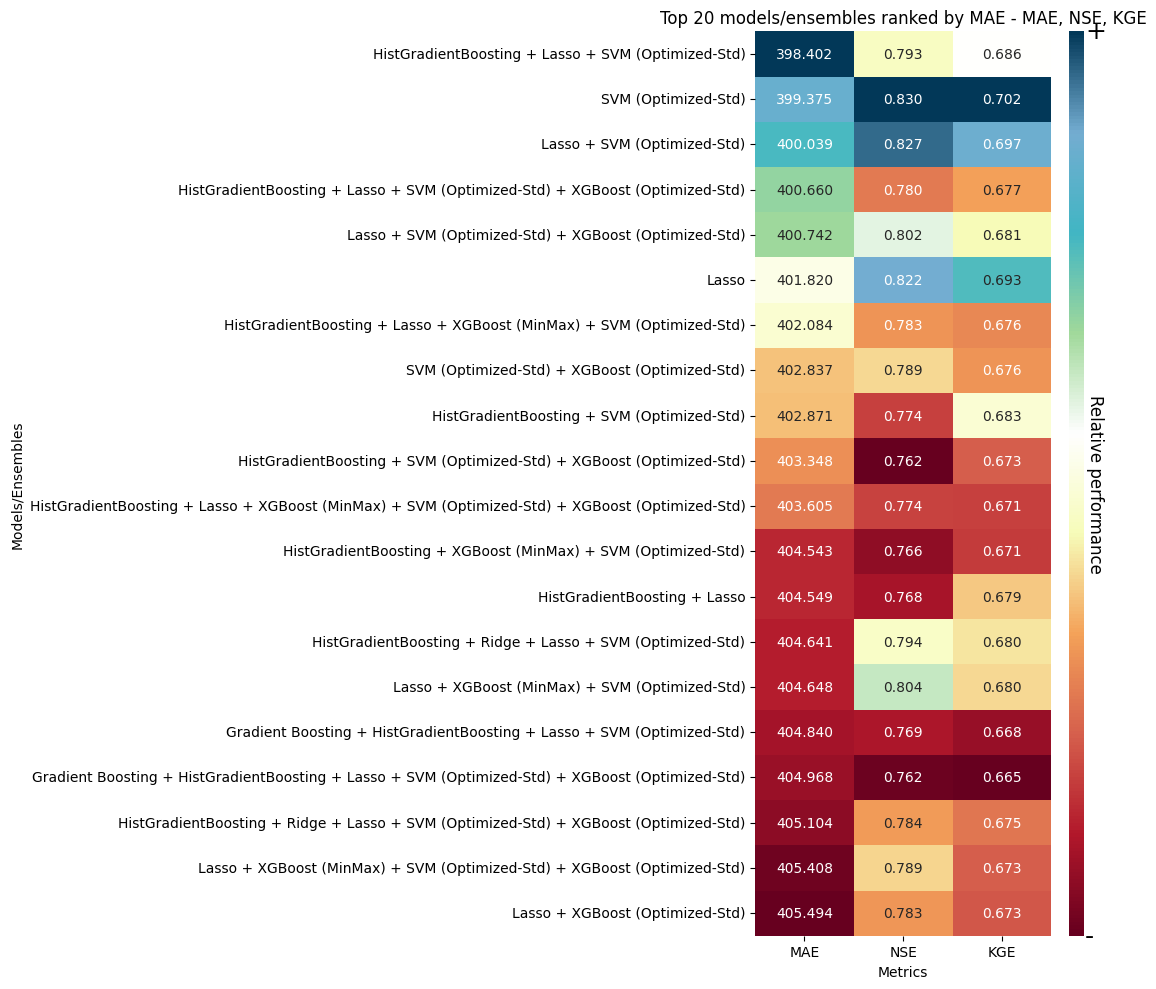

In [ ]:
# "Heatmap displaying the top 20 models/ensembles ranked by MAE, NSE, and KGE.
# The figure highlights relative performance using a custom color scale.
# Only models/ensembles with up to 5 individual models are included.
# The window of days used for evaluation is automatically identified from the input filename and included in the saved figure name."


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
from matplotlib.colors import LinearSegmentedColormap

gdrive_base_folder = '/content/drive/MyDrive/GeoBSF/'

# Infer window of days from filename (assuming data_path contains the file name)
def infer_window_from_filename(filename):
    match = re.search(r'(\d+)dia', filename)
    if match:
        return int(match.group(1))
    return None

# Example: use data_path as in your notebook
janela_dias = infer_window_from_filename(os.path.basename(data_path))

metrics = ['MAE', 'NSE', 'KGE']
metrics_info = {'MAE': False, 'NSE': True, 'KGE': True}
top_n = 20

def count_models(name):
    return len(name.split(' + '))

filtered_results = results_df[results_df['Modelos'].apply(count_models) <= 5]
top_df = filtered_results.sort_values(by='MAE', ascending=True).head(top_n)
model_labels = top_df['Modelos']

def normalize_metrics(df, metrics_info):
    normed = df.copy()
    for col, higher_is_better in metrics_info.items():
        vals = normed[col].values
        if higher_is_better:
            normed[col] = (vals - np.min(vals)) / (np.max(vals) - np.min(vals) + 1e-8)
        else:
            normed[col] = (np.max(vals) - vals) / (np.max(vals) - np.min(vals) + 1e-8)
    return normed

df_metrics = top_df[metrics]
df_normed = normalize_metrics(df_metrics, metrics_info)

colors = [
    "#67001f", # less highlighted (base)
    "#b2182b", "#d6604d", "#f4a259", "#f7fcb9", "#ffffff",
    "#a1d99b", "#41b6c4", "#74add1", "#023858"  # more highlighted (top)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", colors, N=256)

fig, ax = plt.subplots(figsize=(12, len(top_df)*0.5))
sns.heatmap(
    df_normed,
    annot=df_metrics, fmt=".3f",
    cmap=custom_cmap,
    yticklabels=model_labels,
    cbar=False,
    ax=ax
)
plt.title(f'Top {top_n} models/ensembles ranked by MAE - MAE, NSE, KGE')
plt.xlabel('Metrics')
plt.ylabel('Models/Ensembles')
plt.tight_layout(rect=[0, 0, 0.92, 1])  # space for legend

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.18)

gradient = np.linspace(1, 0, 256).reshape(-1,1)
cax.imshow(gradient, aspect='auto', cmap=custom_cmap)
cax.set_xticks([])
cax.set_yticks([])

cax.text(1.08, 0, "-", va='center', ha='left', fontsize=18, color='black', transform=cax.transAxes)
cax.text(1.08, 1, "+", va='center', ha='left', fontsize=18, color='black', transform=cax.transAxes)
cax.text(1.12, 0.5, "Relative performance", va='center', ha='left', fontsize=12, color='black', rotation=270, transform=cax.transAxes)

for spine in cax.spines.values():
    spine.set_visible(False)

# Save figure as JPEG 300 dpi with appropriate name
if janela_dias is not None:
    fig_filename = f"heatmap_top{top_n}_models_MAE_NSE_KGE_{janela_dias}d.jpeg"
else:
    fig_filename = f"heatmap_top{top_n}_models_MAE_NSE_KGE.jpeg"
fig_path = os.path.join(gdrive_base_folder, fig_filename)
plt.savefig(fig_path, format='jpeg', dpi=300, bbox_inches='tight')
print(f"Figure saved: {fig_path}")

plt.show()


Top 5 models/ensembles for groups of 1 model(s) by MAE:
                    Modelos         MAE       NSE       KGE
12      SVM (Optimized-Std)  399.374714  0.829895  0.702208
8                     Lasso  401.819916  0.822088  0.693277
13  XGBoost (Optimized-Std)  417.875452  0.727540  0.656239
7                     Ridge  430.122918  0.790729  0.666494
11         XGBoost (MinMax)  431.289185  0.731548  0.654008
Figure saved: /content/drive/MyDrive/GeoBSF/scatter_top5_ensembles_group1_30d.jpeg


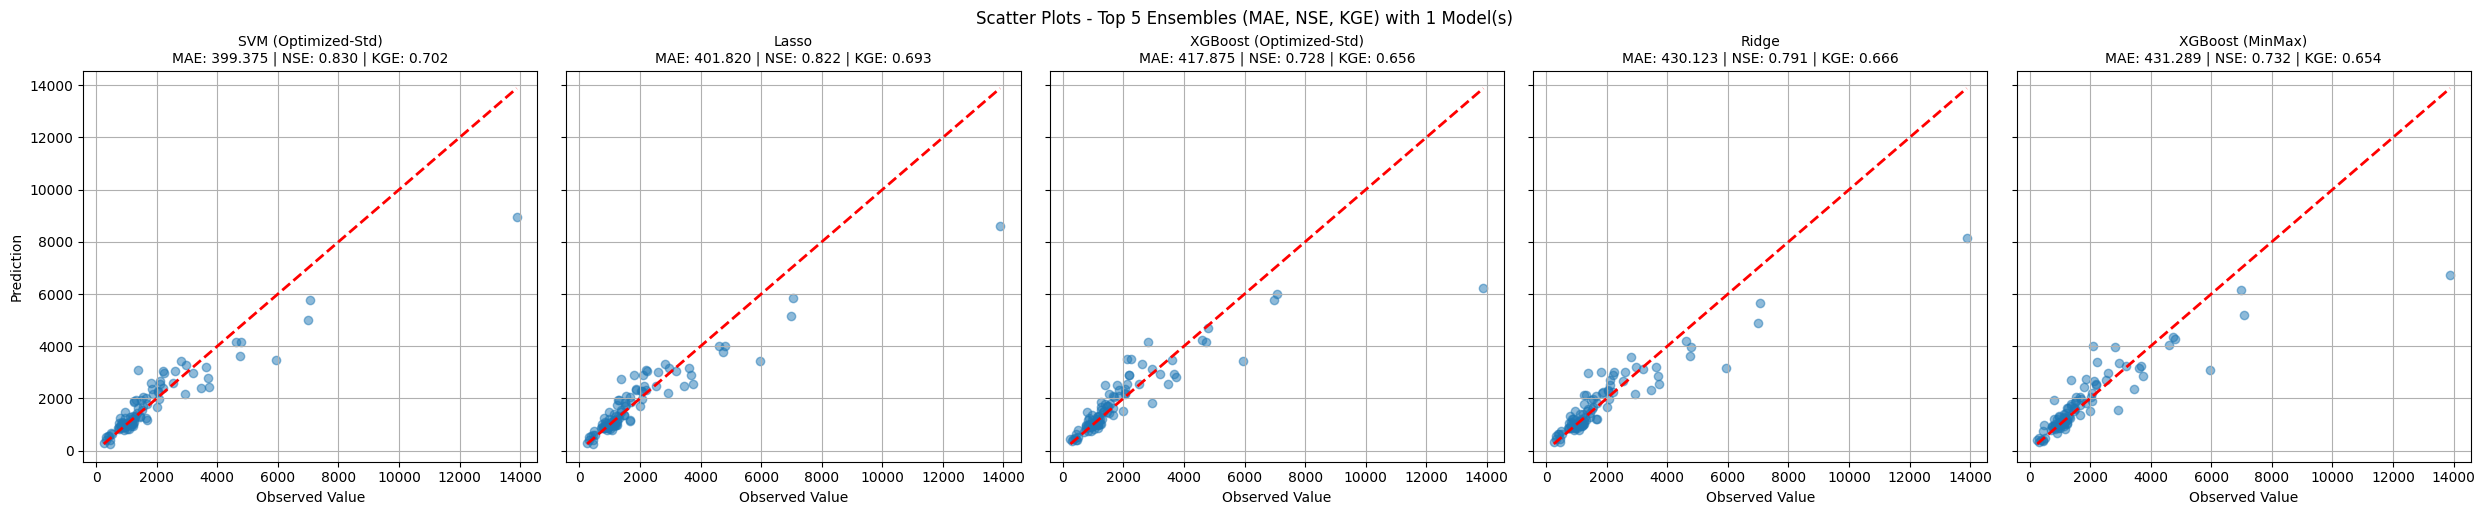


Top 5 models/ensembles for groups of 2 model(s) by MAE:
                                           Modelos         MAE       NSE  \
111                    Lasso + SVM (Optimized-Std)  400.039403  0.826594   
130  SVM (Optimized-Std) + XGBoost (Optimized-Std)  402.837256  0.788978   
77      HistGradientBoosting + SVM (Optimized-Std)  402.870904  0.773753   
73                    HistGradientBoosting + Lasso  404.548936  0.768401   
112                Lasso + XGBoost (Optimized-Std)  405.494454  0.783291   

          KGE  
111  0.697453  
130  0.676463  
77   0.683082  
73   0.679045  
112  0.672647  
Figure saved: /content/drive/MyDrive/GeoBSF/scatter_top5_ensembles_group2_30d.jpeg


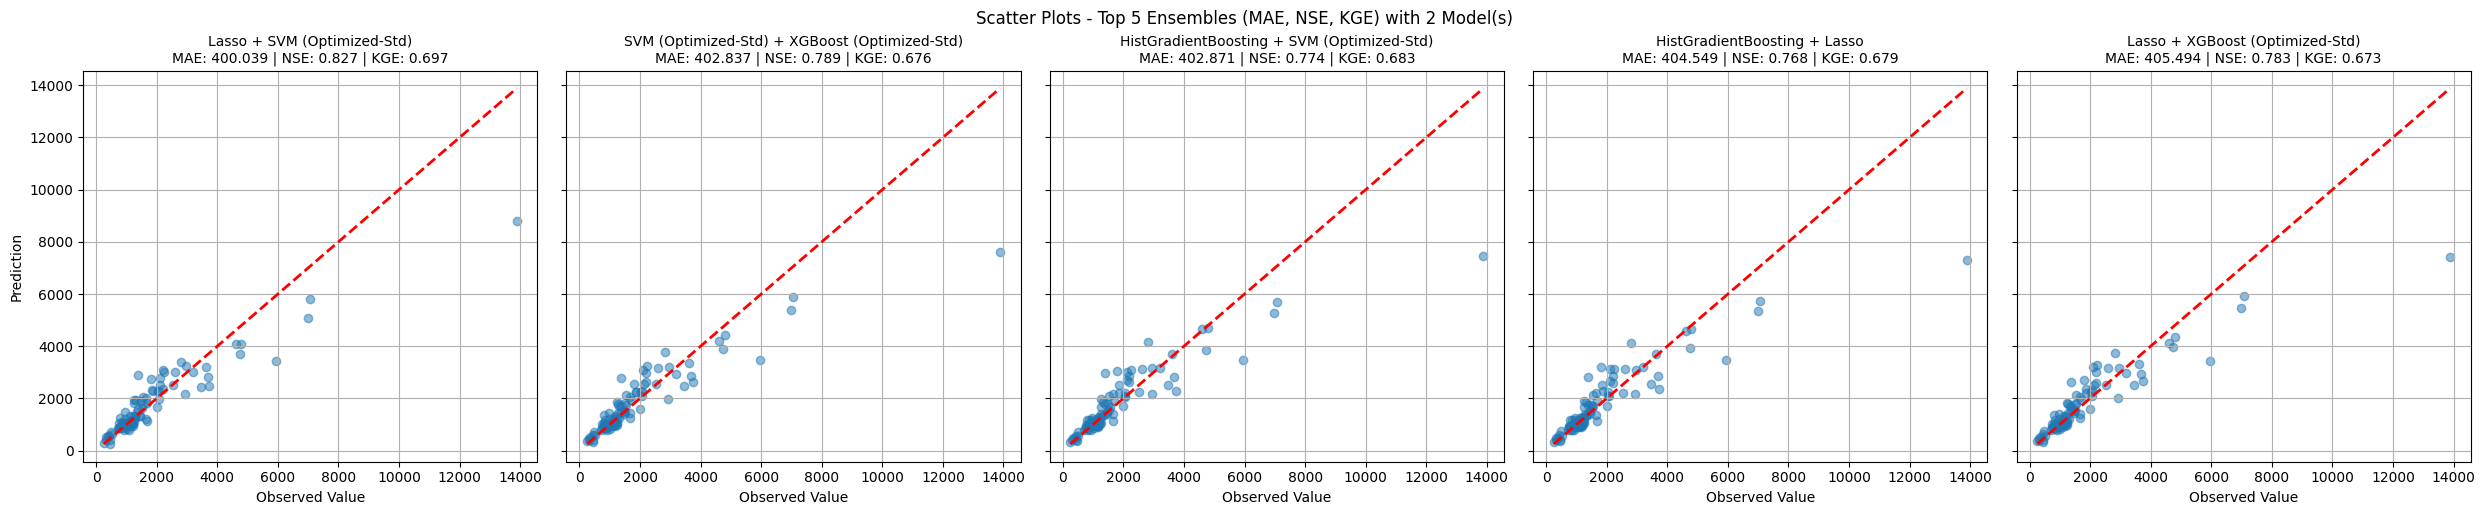


Top 5 models/ensembles for groups of 3 model(s) by MAE:
                                               Modelos         MAE       NSE  \
506  HistGradientBoosting + Lasso + SVM (Optimized-...  398.402051  0.793016   
655  Lasso + SVM (Optimized-Std) + XGBoost (Optimiz...  400.741693  0.801770   
525  HistGradientBoosting + SVM (Optimized-Std) + X...  403.347565  0.761798   
521  HistGradientBoosting + XGBoost (MinMax) + SVM ...  404.542913  0.765969   
651     Lasso + XGBoost (MinMax) + SVM (Optimized-Std)  404.647645  0.804222   

          KGE  
506  0.685569  
655  0.681430  
525  0.673070  
521  0.671102  
651  0.679884  
Figure saved: /content/drive/MyDrive/GeoBSF/scatter_top5_ensembles_group3_30d.jpeg


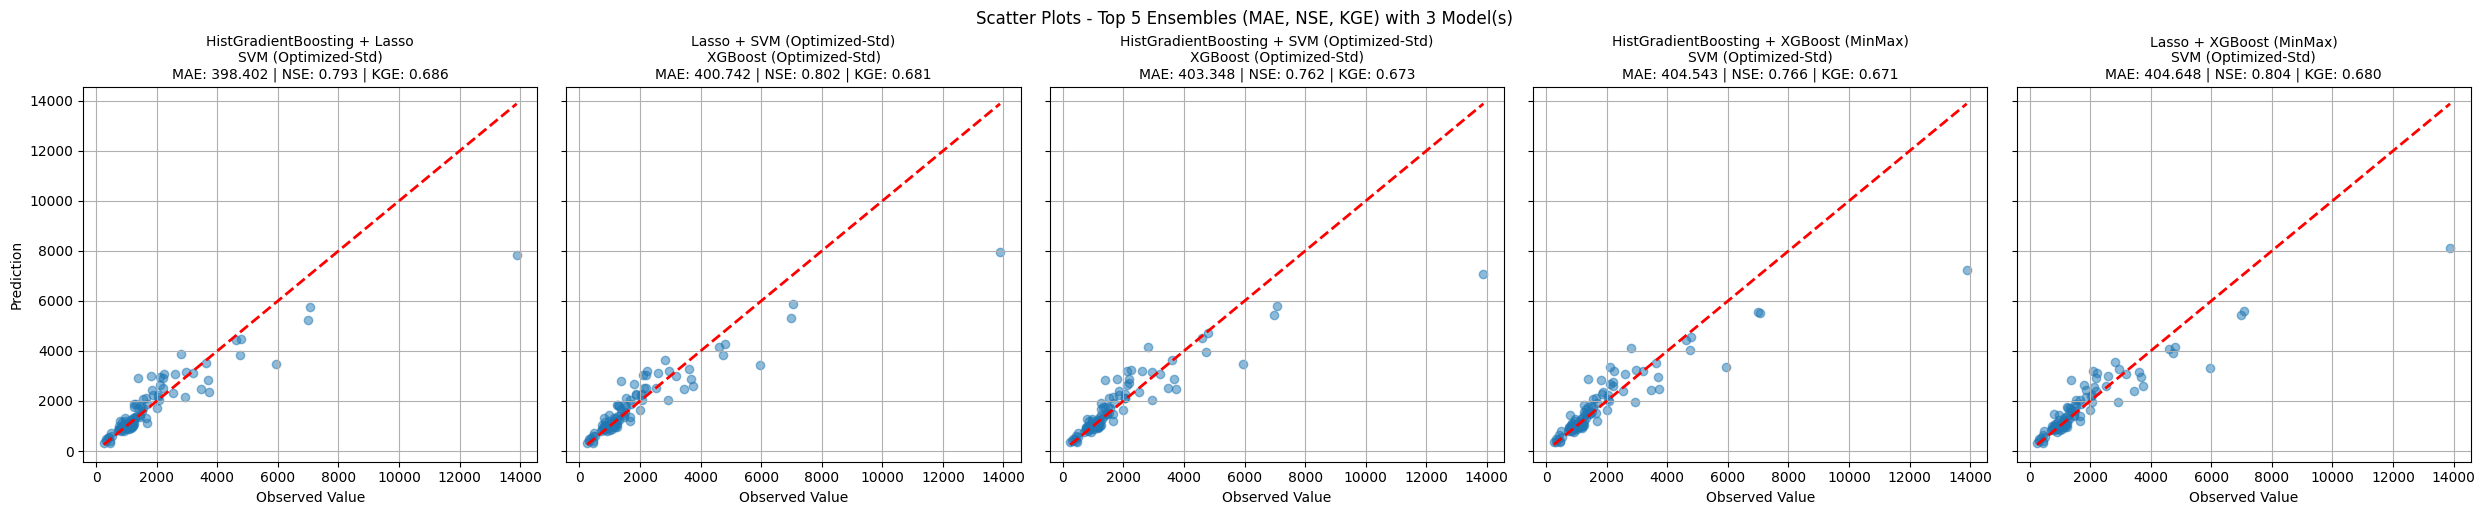


Top 5 models/ensembles for groups of 4 model(s) by MAE:
                                                Modelos         MAE       NSE  \
2145  HistGradientBoosting + Lasso + SVM (Optimized-...  400.659996  0.780116   
2141  HistGradientBoosting + Lasso + XGBoost (MinMax...  402.083518  0.783002   
2105  HistGradientBoosting + Ridge + Lasso + SVM (Op...  404.641298  0.793578   
1325  Gradient Boosting + HistGradientBoosting + Las...  404.839546  0.768878   
2471  Lasso + XGBoost (MinMax) + SVM (Optimized-Std)...  405.407754  0.788693   

           KGE  
2145  0.677279  
2141  0.675776  
2105  0.680355  
1325  0.667671  
2471  0.673134  
Figure saved: /content/drive/MyDrive/GeoBSF/scatter_top5_ensembles_group4_30d.jpeg


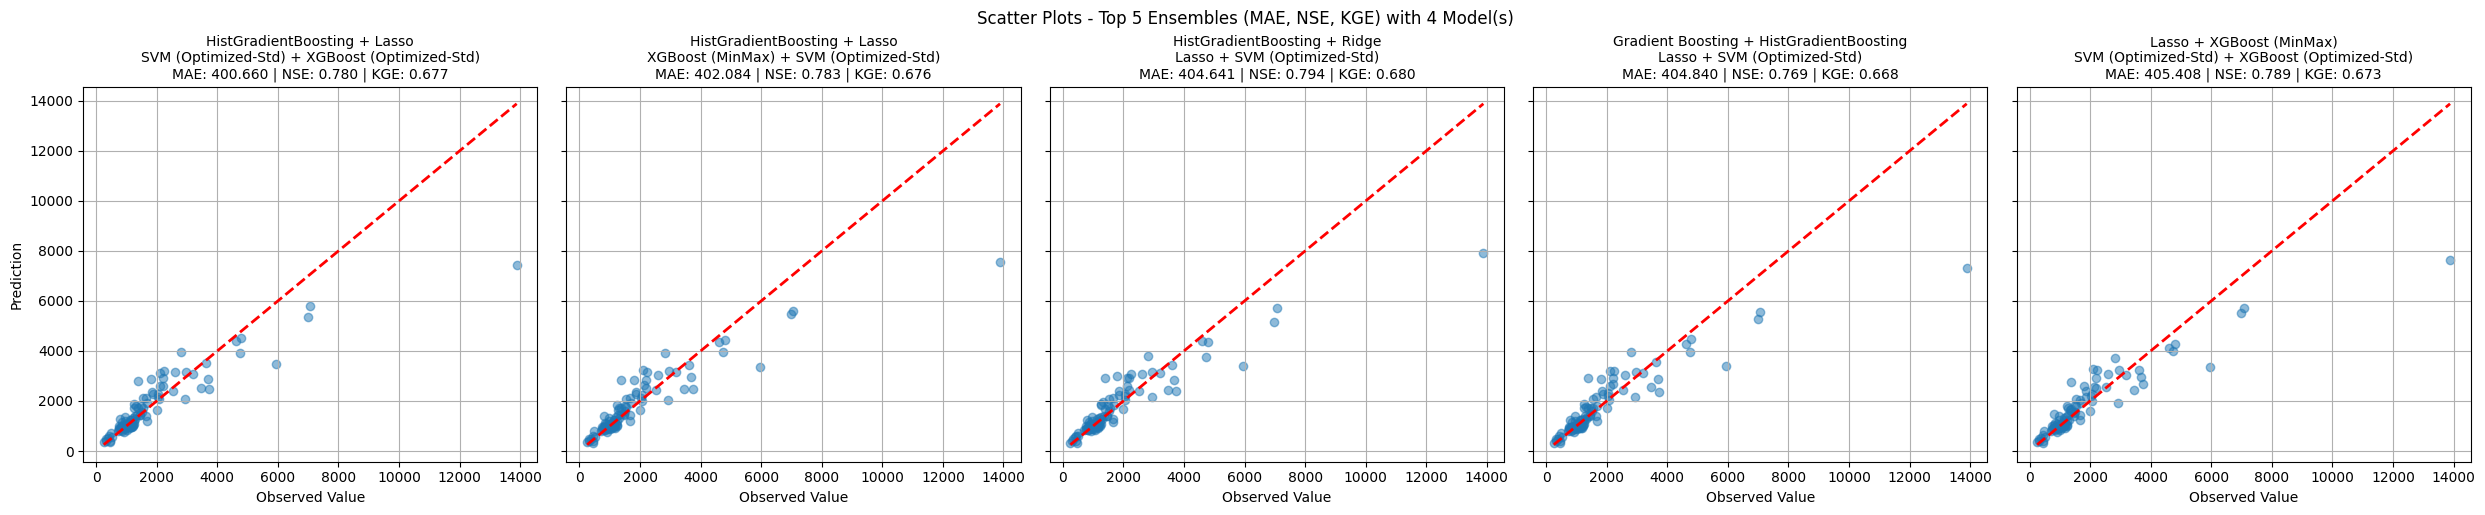


Top 5 models/ensembles for groups of 5 model(s) by MAE:
                                                Modelos         MAE       NSE  \
6377  HistGradientBoosting + Lasso + XGBoost (MinMax...  403.604766  0.773771   
4511  Gradient Boosting + HistGradientBoosting + Las...  404.967786  0.762394   
6311  HistGradientBoosting + Ridge + Lasso + SVM (Op...  405.103805  0.783680   
6307  HistGradientBoosting + Ridge + Lasso + XGBoost...  406.085302  0.785906   
4507  Gradient Boosting + HistGradientBoosting + Las...  406.419304  0.764646   

           KGE  
6377  0.671420  
4511  0.664903  
6311  0.674573  
6307  0.673367  
4507  0.663765  
Figure saved: /content/drive/MyDrive/GeoBSF/scatter_top5_ensembles_group5_30d.jpeg


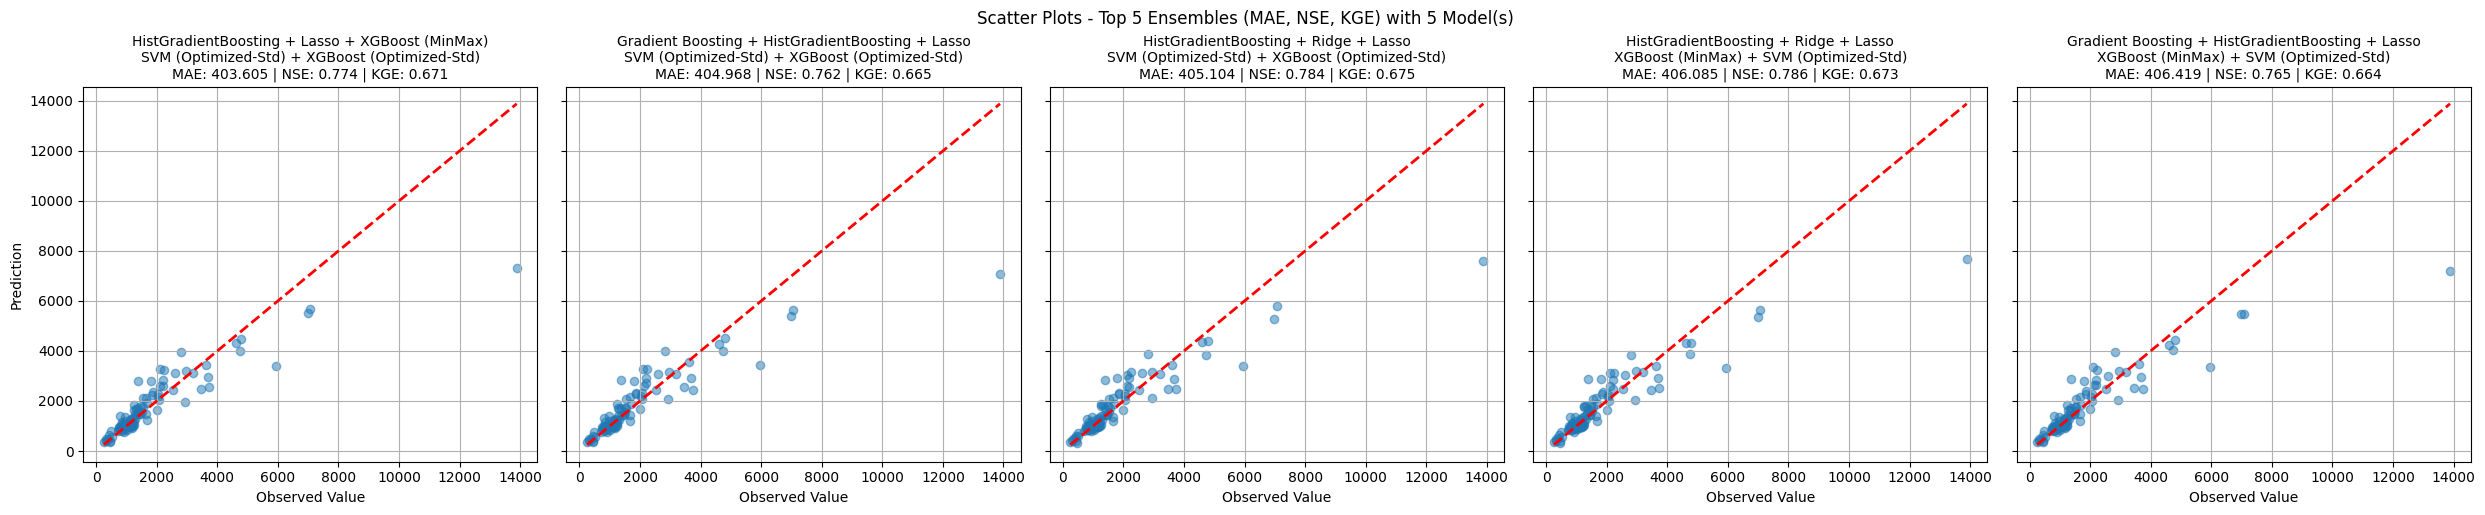

In [ ]:
# "Scatter plots of observed versus predicted values for the top 5 models/ensembles by MAE, grouped by ensemble size (from 1 to 5 models).
# Each subplot includes a reference line for ideal predictions and model performance indicators (MAE, NSE, KGE) in the title.
# Figures are saved with filenames encoding the ensemble group and window of days used for evaluation."


import math
import os
import re

gdrive_base_folder = '/content/drive/MyDrive/GeoBSF/'

# Infer window of days from filename (assuming data_path contains the file name)
def infer_window_from_filename(filename):
    match = re.search(r'(\d+)dia', filename)
    if match:
        return int(match.group(1))
    return None

janela_dias = infer_window_from_filename(os.path.basename(data_path))

# Sort results by number of models and then by MAE (lower is better)
results_df_sorted = results_df.sort_values(by=['Num_Modelos', 'MAE'], ascending=[True, True])

# Ensure y_val is a NumPy array for plotting
y_val_np_plot = y_val.to_numpy() if hasattr(y_val, 'to_numpy') else y_val

def break_ensemble_name(name):
    if ' + ' in name:
        models = name.split(' + ')
        if len(models) > 2:
            n = len(models)
            half = math.ceil(n / 2)
            line1 = ' + '.join(models[:half])
            line2 = ' + '.join(models[half:])
            return line1 + '\n' + line2
    return name

for num_models_group in range(1, 6):
    print(f"\nTop 5 models/ensembles for groups of {num_models_group} model(s) by MAE:")

    filtered_results = results_df_sorted.query(f"Num_Modelos == {num_models_group}")
    top_5_models_in_group = filtered_results.head(5)

    if not top_5_models_in_group.empty:
        print(top_5_models_in_group[['Modelos', 'MAE', 'NSE', 'KGE']])

        fig, axes = plt.subplots(1, len(top_5_models_in_group), figsize=(5 * len(top_5_models_in_group), 5), sharey=True)
        if len(top_5_models_in_group) == 1:
            axes = [axes]
        axes = np.array(axes).flatten()

        for i, (index, row) in enumerate(top_5_models_in_group.iterrows()):
            model_name = row['Modelos']
            model_name_broken = break_ensemble_name(model_name)
            if ' + ' in model_name:
                individual_models = model_name.split(' + ')
                ensemble_preds = np.mean([preds_val[name].to_numpy() if hasattr(preds_val[name], 'to_numpy') else preds_val[name] for name in individual_models], axis=0)
                y_pred_plot = ensemble_preds
            else:
                y_pred_plot = preds_val[model_name].to_numpy() if hasattr(preds_val[model_name], 'to_numpy') else preds_val[model_name]

            axes[i].scatter(y_val_np_plot, y_pred_plot, alpha=0.5)
            axes[i].plot([y_val_np_plot.min(), y_val_np_plot.max()], [y_val_np_plot.min(), y_val_np_plot.max()], 'r--', lw=2)
            axes[i].set_title(
                f'{model_name_broken}\nMAE: {row["MAE"]:.3f} | NSE: {row["NSE"]:.3f} | KGE: {row["KGE"]:.3f}',
                fontsize=10
            )
            axes[i].set_xlabel('Observed Value')
            if i == 0:
                axes[i].set_ylabel('Prediction')
            axes[i].grid(True)

        plt.tight_layout()
        plt.suptitle(f'Scatter Plots - Top 5 Ensembles (MAE, NSE, KGE) with {num_models_group} Model(s)', y=1.02)

        # Save figure as JPEG 300 dpi with appropriate name
        if janela_dias is not None:
            fig_filename = f"scatter_top5_ensembles_group{num_models_group}_{janela_dias}d.jpeg"
        else:
            fig_filename = f"scatter_top5_ensembles_group{num_models_group}.jpeg"
        fig_path = os.path.join(gdrive_base_folder, fig_filename)
        plt.savefig(fig_path, format='jpeg', dpi=300, bbox_inches='tight')
        print(f"Figure saved: {fig_path}")

        plt.show()
    else:
        print(f"No ensemble with {num_models_group} model(s) found.")


Plotting moving averages (with selected window) of the observed series and predictions of the Top 5 models by MAE.
Top 5 models by MAE results:
                                                Modelos         MAE       NSE  \
506   HistGradientBoosting + Lasso + SVM (Optimized-...  398.402051  0.793016   
12                                  SVM (Optimized-Std)  399.374714  0.829895   
111                         Lasso + SVM (Optimized-Std)  400.039403  0.826594   
2145  HistGradientBoosting + Lasso + SVM (Optimized-...  400.659996  0.780116   
655   Lasso + SVM (Optimized-Std) + XGBoost (Optimiz...  400.741693  0.801770   

           KGE  
506   0.685569  
12    0.702208  
111   0.697453  
2145  0.677279  
655   0.681430  
Enter the window size for moving average (e.g.: 10): 1
Figure saved: /content/drive/MyDrive/GeoBSF/moving_average_series_top5_MAE_30d_win1.jpeg


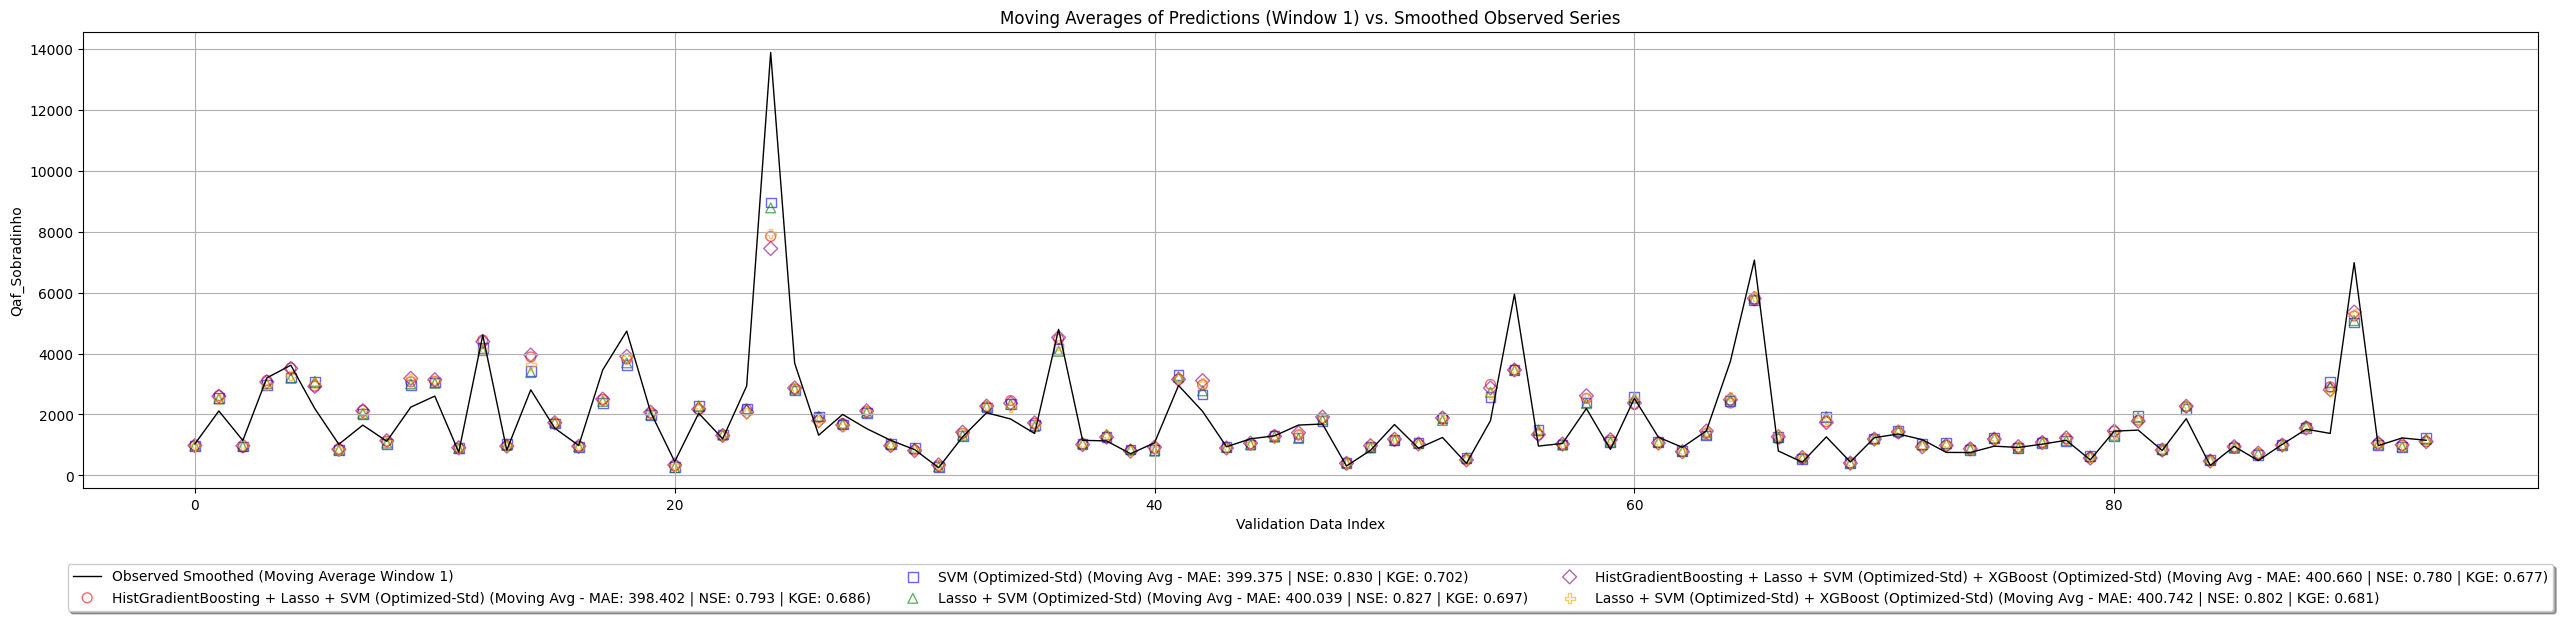

In [ ]:
# "Time series plots showing moving averages (with user-defined window size) of observed and predicted values for the top 5 models/ensembles ranked by MAE.
# The observed series is plotted alongside the smoothed predictions for each model/ensemble.
# Performance metrics (MAE, NSE, KGE) are included in the legend.
# The window of days and moving average window are encoded in the figure filename."


import os
import re

gdrive_base_folder = '/content/drive/MyDrive/GeoBSF/'

# Infer window of days from filename (assuming data_path contains the file name)
def infer_window_from_filename(filename):
    match = re.search(r'(\d+)dia', filename)
    if match:
        return int(match.group(1))
    return None

janela_dias = infer_window_from_filename(os.path.basename(data_path))

def count_models(name):
    return len(name.split(' + '))

results_df_sorted_mae = results_df.sort_values(by='MAE', ascending=True)
results_df_sorted_mae_max5 = results_df_sorted_mae[results_df_sorted_mae['Modelos'].apply(count_models) <= 5]
top_5_mae_models = results_df_sorted_mae_max5.head(5)

print("\nPlotting moving averages (with selected window) of the observed series and predictions of the Top 5 models by MAE.")
print("Top 5 models by MAE results:")
print(top_5_mae_models[['Modelos', 'MAE', 'NSE', 'KGE']])

y_val_np_plot = y_val.to_numpy() if hasattr(y_val, 'to_numpy') else y_val
x_val_indices = np.arange(len(y_val_np_plot))

while True:
    try:
        window_size_input = input("Enter the window size for moving average (e.g.: 10): ")
        window_size = int(window_size_input)
        if window_size <= 0:
            print("Window size must be a positive integer.")
        elif window_size > len(y_val_np_plot):
            print(f"Window size cannot be greater than the number of validation points ({len(y_val_np_plot)}).")
        else:
            break
    except ValueError:
        print("Invalid input. Enter an integer.")

plt.figure(figsize=(28, 7))

y_val_pd_series = pd.Series(y_val_np_plot)
y_val_smoothed = y_val_pd_series.rolling(window=window_size, center=True).mean()
plt.plot(x_val_indices, y_val_smoothed, label=f'Observed Smoothed (Moving Average Window {window_size})', color='black', linewidth=1)

colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'P']
marker_size = 50

for i, (index, row) in enumerate(top_5_mae_models.iterrows()):
    model_name = row['Modelos']
    if ' + ' in model_name:
        individual_models = model_name.split(' + ')
        ensemble_preds = np.mean([preds_val[name].to_numpy() if hasattr(preds_val[name], 'to_numpy') else preds_val[name] for name in individual_models], axis=0)
        y_pred_plot = ensemble_preds
    else:
        y_pred_plot = preds_val[model_name].to_numpy() if hasattr(preds_val[model_name], 'to_numpy') else preds_val[model_name]

    y_pred_pd_series = pd.Series(y_pred_plot)
    y_pred_smoothed = y_pred_pd_series.rolling(window=window_size, center=True).mean()

    plt.scatter(
        x_val_indices, y_pred_smoothed,
        label=f'{model_name} (Moving Avg - MAE: {row["MAE"]:.3f} | NSE: {row["NSE"]:.3f} | KGE: {row["KGE"]:.3f})',
        facecolors='none',
        edgecolors=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        s=marker_size,
        alpha=0.6
    )

plt.xlabel('Validation Data Index')
plt.ylabel(target_variable)
plt.title(f'Moving Averages of Predictions (Window {window_size}) vs. Smoothed Observed Series')
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save figure as JPEG 300 dpi with appropriate name
if janela_dias is not None:
    fig_filename = f"moving_average_series_top5_MAE_{janela_dias}d_win{window_size}.jpeg"
else:
    fig_filename = f"moving_average_series_top5_MAE_win{window_size}.jpeg"
fig_path = os.path.join(gdrive_base_folder, fig_filename)
plt.savefig(fig_path, format='jpeg', dpi=300, bbox_inches='tight')
print(f"Figure saved: {fig_path}")

plt.show()